<a href="https://colab.research.google.com/github/WRD397/Practices/blob/main/GPT2_dolly_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer
from torch.optim import Adam
from torch.utils.data import DataLoader
import tqdm
import torch
from torch.utils.data import Dataset
import json
import pandas as pd

## Specifying Device

In [7]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

## Model and Tokenizer

In [8]:
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
tokenizer.add_special_tokens({"pad_token": "<pad>", 
                                "bos_token": "<startofstring>",
                                "eos_token": "<endofstring>"})

3

In [9]:
tokenizer.add_tokens(["<bot>:"])

1

In [10]:
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.resize_token_embeddings(len(tokenizer))

Embedding(50261, 768)

In [11]:
model = model.to(device)

# Loading Dataset

In [12]:
data_jsonl = pd.read_json('/content/drive/MyDrive/SelfProject/chatbot_dolly/data/databricks-dolly-15k.jsonl', lines=True)

In [13]:
data_jsonl.head()

,instruction,context,response,category
0,When did Virgin Australia start operating?,"Virgin Australia, the trading name of Virgin A...",Virgin Australia commenced services on 31 Augu...,closed_qa
1,Which is a species of fish? Tope or Rope,,Tope,classification
2,Why can camels survive for long without water?,,Camels use the fat in their humps to keep them...,open_qa
3,"Alice's parents have three daughters: Amy, Jes...",,The name of the third daughter is Alice,open_qa
4,When was Tomoaki Komorida born?,Komorida was born in Kumamoto Prefecture on Ju...,"Tomoaki Komorida was born on July 10,1981.",closed_qa


In [14]:
data_jsonl.isnull().mean()

instruction    0.0
context        0.0
response       0.0
category       0.0
dtype: float64

In [15]:
data_jsonl['context'][:10]

0    Virgin Australia, the trading name of Virgin A...
1                                                     
2                                                     
3                                                     
4    Komorida was born in Kumamoto Prefecture on Ju...
5    Stalemate is a situation in chess where the pl...
6    Lollapalooza /ˌlɒləpəˈluːzə/ (Lolla) is an ann...
7                                                     
8                                                     
9    John Moses Browning (January 23, 1855 – Novemb...
Name: context, dtype: object

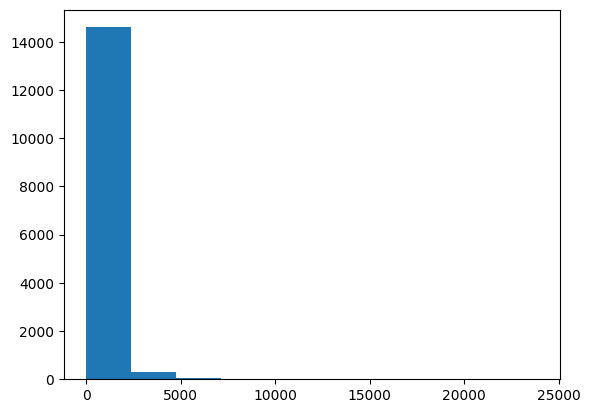

In [16]:
import matplotlib.pyplot as plt
plt.hist([len(item) for item in data_jsonl['context']])
plt.show()

Now, let’s turn our labels and encodings into a Dataset object. In PyTorch, this is done by subclassing a torch.utils.data.Dataset object and implementing `__len__` and  `__getitem__`

In [21]:
class ChatData(Dataset):
    def __init__(self, path, tokenizer):
        self.data = pd.read_json(path, lines=True)
        self.X = []
        for item in self.data['context']:
            self.X.append(item)

        self.X = self.X[:100]

        for idx, i in enumerate(self.X):
            try:
                self.X[idx] = "<startofstring> "+i+" <bot>: "+self.X[idx+1]+" <endofstring>"
            except:
                break

        self.X_encoded = tokenizer(self.X, truncation=True, padding = True, return_tensors="pt")
        self.input_ids = self.X_encoded['input_ids']
        self.attention_mask = self.X_encoded['attention_mask']

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (self.input_ids[idx], self.attention_mask[idx])

In [22]:
chatData = ChatData('/content/drive/MyDrive/SelfProject/chatbot_dolly/data/databricks-dolly-15k.jsonl', tokenizer)
chatData =  DataLoader(chatData)

# Training

In [23]:
def train(chatData, model, optim):
    epochs = 20
    for i in tqdm.tqdm(range(epochs)):
        for X, a in chatData:
            X = X.to(device)
            a = a.to(device)
            optim.zero_grad()
            loss = model(X, attention_mask=a, labels=X).loss
            loss.backward()
            optim.step()
        torch.save(model.state_dict(), '/content/drive/MyDrive/SelfProject/chatbot_dolly/results/model_state.pt')

In [24]:
train(chatData = chatData, 
      model = model, 
      optim = Adam(model.parameters()))

  0%|          | 0/20 [52:48<?, ?it/s]


KeyboardInterrupt: ignored